In [1]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from utility_fun import *

In [2]:
path = 'C:/Users/mirshams/Dropbox (University of Michigan)/Ultrasound Research Lab Data/SHAPE Payam Debug/'
fname = '18SMP.DCM'

roi_cntr = (np.nan, 1.4)  # center of elliptical roi, cm
roi_a = 0.5  # semi-major axis of the elliptical roi, cm
roi_b = 0.15  # semi-minor axis of the elliptical roi, cm

ds = pydicom.dcmread(path + fname)
pixel_data = ds.pixel_array

In [3]:
cntrst_data,_,_ = extract_region_data(pixel_data, ds[0x00186011], image_type='CEUS')

red_tag = ds[0x00631036].value
green_tag = ds[0x00631037].value
blue_tag = ds[0x00631038].value
Color_Pallet = create_color_pallet(red_tag, green_tag, blue_tag, show_fig = False)

cntrst_dB_array, cntrst_amp_array, DR = \
    amplitude_find(cntrst_data, Color_Pallet, DR = 60, Method = 'meanRGB')
# Just a rectangle across
cntrst_amp_rect_mean = np.mean(cntrst_amp_array[:, 250:300, :], axis=(1, 2))
cntrst_dB_rect_mean = np.mean(cntrst_dB_array[:, 250:300, :], axis=(1, 2))
# ROI as determined by Kourosh
region_cntrst = ds[0x00186011][1]
x_cntrst, y_cntrst, xx_cntrst, yy_cntrst, roi_contours = (
    cart_grid_and_roi_maker(region_cntrst, roi_a, roi_b, roi_cntr))
roi = (roi_contours <= 1)
ROI = np.tile(roi, [cntrst_amp_array.shape[0], 1, 1])
cntrst_amp_masked = np.multiply(cntrst_amp_array, ROI)
cntrst_amp_ROI_mean = np.true_divide(np.sum(cntrst_amp_masked, axis=(1,2)), np.sum(ROI, axis= (1,2)))

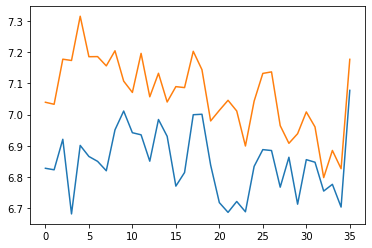

In [4]:
# print(cntrst_amp_rect_mean)
# plt.plot(cntrst_amp_rect_mean)
plt.plot(cntrst_amp_rect_mean)
plt.plot(cntrst_amp_ROI_mean)

In [20]:
# b-mode region, dicom object, dataset
region_b = ds[0x00186011][0]
# contrast mode region, dicom object, dataset
region_cntrst = ds[0x00186011][1]
# b-mode image stored in public field
image_b, image_width_pixel_b, image_height_pixel_b = \
    extract_region_data(pixel_data, ds[0x00186011], image_type='bmode')
# cntrst mode image stored in public field
image_cntrst, image_width_pixel_cntrst, image_height_pixel_cntrst = \
    extract_region_data(pixel_data, ds[0x00186011], image_type='CEUS')

image_width_cm_b = image_width_pixel_b * region_b.PhysicalDeltaX
image_height_cm_b = image_height_pixel_b * region_b.PhysicalDeltaY
image_width_cm_cntrst = image_width_pixel_cntrst * region_b.PhysicalDeltaX
image_height_cm_cntrst = image_height_pixel_cntrst * region_b.PhysicalDeltaY

x_cntrst, y_cntrst, xx_cntrst, yy_cntrst, roi_contours = (
    cart_grid_and_roi_maker(region_cntrst, roi_a, roi_b, roi_cntr))

# ---------------------- Private fields ---------------------- #
unknown_arr = ds[0x00631034].value
unknown_arr = unknown_arr.split('\\')
unknown_arr = np.array(unknown_arr)
unknown_arr = unknown_arr.astype(float)

# receive frequency in MHz?!!
receive_frq = float(ds[0x00631041].value)

# anti-log vector?!
anti_log_vec = ds[0x00631032].value
anti_log_vec = anti_log_vec.split('\\')
anti_log_vec = np.array(anti_log_vec)
anti_log_vec = anti_log_vec.astype(float)

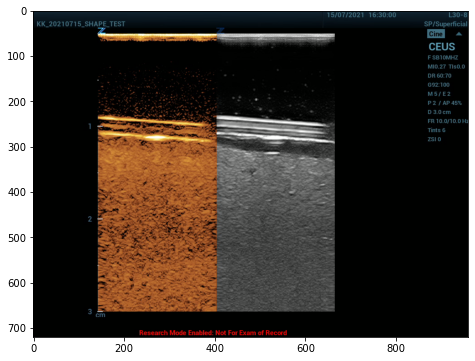

In [21]:
# ---------------------- Illustration ---------------------- #
# Pick a frame number for illustration purposes
i_frame = 0
i_frame_full_img = pixel_data[i_frame, :, :, :]
i_frame_img_b = image_b[i_frame, ...]
i_frame_img_cntrst = image_cntrst[i_frame, ...]

# full image (b mode + contrast mode) from public fields
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
ax.imshow(i_frame_full_img)

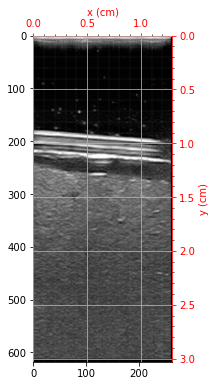

In [22]:
# b-mode image from public fields
fig = plt.figure(figsize=(8, 6))
fig.clear()
ax1 = fig.add_subplot(111, label='1')
ax1.imshow(i_frame_img_b, cmap='gray',
           extent=[0, image_width_pixel_b, image_height_pixel_b, 0],
           aspect='equal')
ax1.spines['right'].set_color('red')
ax1.spines['top'].set_color('red')
ax2 = fig.add_axes(ax1.get_position(), frameon=False)
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlim(0, image_width_cm_b)
ax2.set_ylim(image_height_cm_b, 0)
ax2.set_xlabel('x (cm)', color='red')
ax2.set_ylabel('y (cm)', color='red')
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='x', colors='red')
ax2.tick_params(axis='y', colors='red')
ax1.set_aspect(1)
ax2.set_aspect(1)
ax2.grid(True, which='major')
ax2.grid(True, which='minor', linestyle='--', linewidth=0.1)
ax2.minorticks_on()

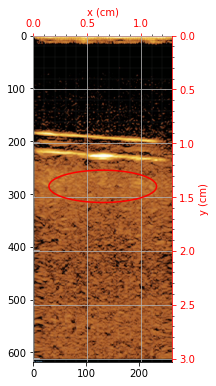

In [23]:
# cntrst mode image from public fields
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111, label='1')
ax1.imshow(
    i_frame_img_cntrst,
    extent=[0, image_width_pixel_cntrst, image_height_pixel_cntrst, 0],
    aspect='equal')
ax1.spines['right'].set_color('red')
ax1.spines['top'].set_color('red')
ax1_xlim = ax1.get_xlim()
ax1_ylim = ax1.get_ylim()
ax2 = fig.add_axes(ax1.get_position(), frameon=False)
ax2.set_aspect('equal')
ax2.set_adjustable('box')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlim(0, image_width_cm_cntrst)
ax2.set_ylim(image_height_cm_cntrst, 0)
ax2.set_xlabel('x (cm)', color='red')
ax2.set_ylabel('y (cm)', color='red')
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='x', colors='red')
ax2.tick_params(axis='y', colors='red')
ax2.grid(True, which='major')
ax2.grid(True, which='minor', linestyle='--', linewidth=0.1)
ax2.minorticks_on()
ax2.contour(xx_cntrst, yy_cntrst, roi_contours, [1], colors='red')

Text(0, 0.5, 'Signal value in au')

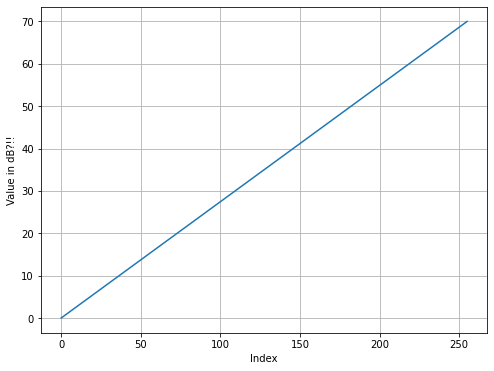

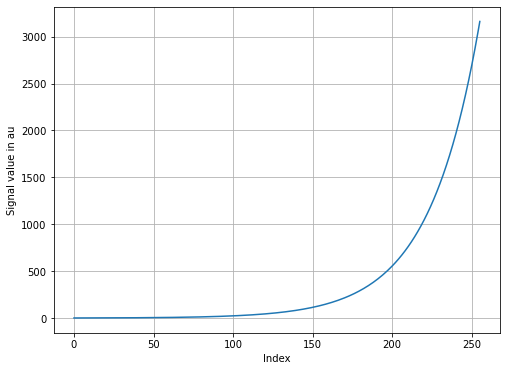

In [35]:
# anti-log vectors
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
ax.plot(20*np.log10(anti_log_vec))
ax.grid(True)
ax.set_xlabel('Index')
ax.set_ylabel('Value in dB?!!')

# anti-log vectors
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
ax.plot(anti_log_vec)
ax.grid(True)
ax.set_xlabel('Index')
ax.set_ylabel('Signal value in au')

In [9]:
pxl_in_roi = i_frame_img_cntrst[roi_contours <= 1]

pxl_in_roi_dB, pxl_in_roi_amp, _ = amplitude_find(pxl_in_roi, Color_Pallet, DR = 60, Method = 'meanRGB')

My_Mean = np.mean(pxl_in_roi_amp)
print(f"Mean amplitude value is {My_Mean}")

Mean amplitude value is 9.79861643101721
